# Opioid Addiction Project
## Notebook 05: Feature Importance

This notebook focuses on calculating feature importance

1. Load trained models from disk
2. Generate feature importance (Shapley values) ...
  * For the overall model
  * For individual predictions, including re-aggregating one-hot encoded values.

Generating feature importance (Shapley values) was originally also part of this notebook, but the long  execution time of model training and calibration made it more efficient to include in a new notebook.

### W210, Capstone
Summer 2019

Team:  Cameron Kennedy, Aditi Khullar, Rachel Kramer, Sharad Varadarajan

# 0. Load Libraries and Set Global Variables
This analysis is performed in the cells below.

In [1]:
#Import Required Libraries

#General libraries
import numpy as np
import pandas as pd
from sklearn.externals import joblib  #Used to save (pickle) models
from collections import defaultdict
import operator
import matplotlib.pyplot as plt
from scipy import stats

#Feature Importance
import shap #conda install -c conda-forge shap
shap.initjs()  #Javascript for Shapley Values

#Debugging / performance
from timeit import default_timer as timer

#Set initial parameter(s)
pd.set_option('display.max_rows', 100)
pd.options.display.max_columns = 200
dataDir = './data/'

C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# 1. Load Data

This step loads the models and data.

In [2]:
start = timer()

#Load Models
modelLR = joblib.load(dataDir+'modelLR.model')
calibratorLR = joblib.load(dataDir+'calibLR.model')

modelXGB = joblib.load(dataDir+'modelXGB.model')
calibratorXGB = joblib.load(dataDir+'calibXGB.model')


#Load data used for feature importance
valX = pd.read_pickle(dataDir+'valX.pickle.zip')
testX = pd.read_pickle(dataDir+'testX.pickle.zip')

end = timer()
print('Run time: {:.1f} seconds'.format(end - start)) # Time in seconds

print(type(modelXGB))
print(type(calibratorXGB))
print(type(valX))
print(type(testX))

Run time: 0.1 seconds
<class 'xgboost.sklearn.XGBClassifier'>
<class 'sklearn.calibration.CalibratedClassifierCV'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [3]:
#Get stats
predProbsLRCal = calibratorLR.predict_proba(testX)[:,1]
print('33%, 50% (median), 67% quantiles:', np.quantile(predProbsLRCal, [1/4, 1/2, 3/4]))
print('Average Score:', np.mean(predProbsLRCal))
print('Percentile of Average Score:',stats.percentileofscore(predProbsLRCal, np.mean(predProbsLRCal)) / 100)

33%, 50% (median), 67% quantiles: [0.06920078 0.08222222 0.24691358]
Average Score: 0.1646139910456368
Percentile of Average Score: 0.6652923538230884


# 2. Feature Importance

This section calculates feature importance for the models, split into two items:

1. Calculate overall feature importance for the model. This will be useful for understanding the model as a whole, and in that sense is akin to EDA, but for the model rather than the raw data.
2. Calculate feature importance for an individual example. This is what will be used when giving individual respondents their score.

As part of these tasks, we will also incorporate aggregating feature importance scores from one-hot encoded features.

In [4]:
#Make a single prediction
for row in range(0,50):
    predM = modelXGB.predict_proba(testX.iloc[[row]])[0][1] #ARGH! Need double brackets for XGBoost model to predict
    predC = calibratorXGB.predict_proba(np.array(testX.iloc[row]).reshape(1, -1))[0][1]
    
    print('Case {}: UNCALIBRATED Prediction: {:.2%}'.format(row, predM))
    print('Case {}:   CALIBRATED Prediction: {:.2%}\n'.format(row, predC))       

Case 0: UNCALIBRATED Prediction: 36.54%
Case 0:   CALIBRATED Prediction: 28.93%

Case 1: UNCALIBRATED Prediction: 39.09%
Case 1:   CALIBRATED Prediction: 75.91%

Case 2: UNCALIBRATED Prediction: 15.78%
Case 2:   CALIBRATED Prediction: 7.53%

Case 3: UNCALIBRATED Prediction: 31.93%
Case 3:   CALIBRATED Prediction: 8.99%

Case 4: UNCALIBRATED Prediction: 66.97%
Case 4:   CALIBRATED Prediction: 78.83%

Case 5: UNCALIBRATED Prediction: 19.92%
Case 5:   CALIBRATED Prediction: 8.99%

Case 6: UNCALIBRATED Prediction: 40.68%
Case 6:   CALIBRATED Prediction: 11.53%

Case 7: UNCALIBRATED Prediction: 46.31%
Case 7:   CALIBRATED Prediction: 21.21%

Case 8: UNCALIBRATED Prediction: 26.54%
Case 8:   CALIBRATED Prediction: 8.82%

Case 9: UNCALIBRATED Prediction: 33.53%
Case 9:   CALIBRATED Prediction: 18.20%

Case 10: UNCALIBRATED Prediction: 27.98%
Case 10:   CALIBRATED Prediction: 10.60%

Case 11: UNCALIBRATED Prediction: 31.52%
Case 11:   CALIBRATED Prediction: 14.76%

Case 12: UNCALIBRATED Predic

In [5]:
#Calculate Shapley Values
#NOTE: Currently this takes a couple minutes to run

#Create XGB Explainer
explainerXGB = shap.TreeExplainer(modelXGB, valX, feature_dependence='independent', model_output='probability')
#Note, very specifically this is where we need XGBoost 0.81 (0.80 failed, and 0.90 killed the kernel).

#Create LR Calibrated Explainer
valX_Kmeans = shap.kmeans(valX, 200)  #with 200 it takes ~1.2 sec to generate a prediction
explainerLRCal = shap.KernelExplainer(calibratorLR.predict_proba, valX_Kmeans)

#OLD WAY (slow because it uses all the background samples, using kmeans instead, above)
#explainerLRCal = shap.KernelExplainer(calibratorLR.predict_proba, valX)


#This helped at one point: https://evgenypogorelov.com/multiclass-xgb-shap.html

'''WARNING MESSAGE:
Using 13340 background data samples could cause slower run times. 
Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.
'''

Using 200 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.


'WARNING MESSAGE:\nUsing 13340 background data samples could cause slower run times. \nConsider using shap.kmeans(data, K) to summarize the background as K weighted samples.\n'

In [6]:
#Save the explainer (for use in the web app)
joblib.dump(explainerXGB, dataDir+'modelXGB.explainer')
joblib.dump(explainerLRCal, dataDir+'modelLRCal.explainer')

['./data/modelLRCal.explainer']

In [7]:
#Overall model inspection
valXSample = valX.sample(100)
shap_valuesLRCal = explainerLRCal.shap_values(valXSample)
shap_valuesXGB = explainerXGB.shap_values(valXSample)

C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\shap\explainers\kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\shap\explainers\kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\shap\explainers\kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) t

C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\shap\explainers\kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\shap\explainers\kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\shap\explainers\kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) t

C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\shap\explainers\kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\shap\explainers\kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\shap\explainers\kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) t

C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\shap\explainers\kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\shap\explainers\kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\shap\explainers\kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) t

C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\shap\explainers\kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\shap\explainers\kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\shap\explainers\kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) t

C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\shap\explainers\kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\shap\explainers\kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\shap\explainers\kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) t

C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\shap\explainers\kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\shap\explainers\kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\shap\explainers\kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) t

C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\shap\explainers\kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\shap\explainers\kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\shap\explainers\kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) t

C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\shap\explainers\kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\shap\explainers\kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\shap\explainers\kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) t

 96%|=================== | 96/100 [00:18<00:00]       

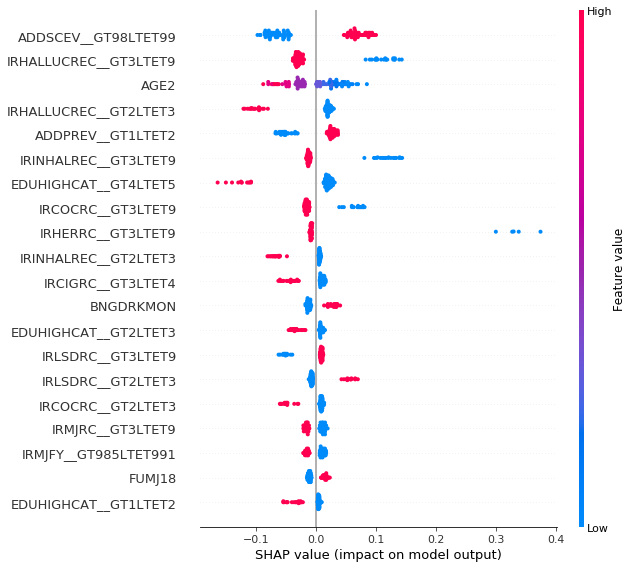

In [8]:
shap.summary_plot(np.array(shap_valuesLRCal)[1], valXSample)

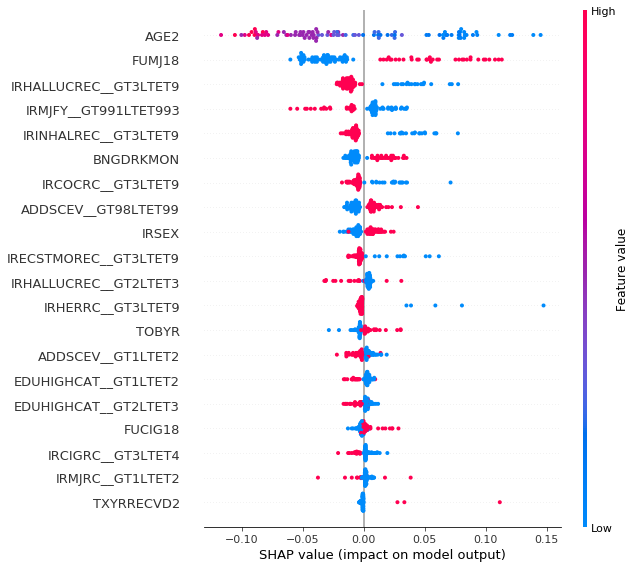

In [9]:
shap.summary_plot(shap_valuesXGB, valXSample)

In [10]:
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

testCaseID = 14

#print(shap_values)
print(shap_valuesXGB.shape)
print(shap_valuesXGB[testCaseID])

(100, 110)
[ 0.     0.     0.     0.     0.     0.001  0.     0.     0.     0.008
  0.122  0.013 -0.002  0.     0.     0.     0.     0.    -0.     0.
 -0.     0.001 -0.    -0.    -0.    -0.    -0.    -0.    -0.    -0.
 -0.004 -0.     0.     0.    -0.001  0.     0.     0.     0.     0.003
 -0.011  0.001  0.     0.028  0.098 -0.002 -0.     0.005  0.001  0.001
 -0.    -0.    -0.     0.    -0.    -0.     0.003 -0.     0.     0.
  0.001  0.     0.004  0.    -0.     0.002 -0.013  0.    -0.    -0.
  0.    -0.    -0.005  0.     0.004 -0.015  0.     0.001 -0.001 -0.
 -0.001  0.035 -0.     0.001 -0.001  0.     0.    -0.001  0.    -0.
 -0.    -0.    -0.     0.    -0.001  0.001  0.     0.    -0.     0.001
 -0.     0.002  0.026  0.006  0.     0.     0.013  0.003 -0.001 -0.   ]


In [11]:
#Notice here how with the LRCal shapley values, we have to take the [1] to get the same
#as the XGB shapley values
print(np.array(shap_valuesLRCal)[1].shape)
print(np.array(shap_valuesLRCal)[1][testCaseID])

(100, 110)
[-0.068  0.     0.     0.     0.    -0.015  0.     0.     0.     0.1
  0.061  0.04   0.     0.     0.     0.     0.     0.     0.     0.
  0.    -0.076  0.     0.     0.     0.     0.     0.     0.     0.
  0.011  0.     0.     0.     0.     0.     0.003  0.011  0.     0.007
 -0.046  0.007  0.031  0.012  0.02   0.     0.     0.008  0.     0.
  0.     0.     0.     0.002  0.     0.     0.027  0.     0.     0.
  0.     0.     0.015  0.011  0.     0.013 -0.019  0.     0.     0.
  0.     0.     0.     0.     0.028 -0.038  0.     0.005 -0.008  0.
 -0.079  0.143  0.    -0.011  0.012  0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.033  0.     0.     0.     0.
  0.     0.016  0.012  0.     0.011  0.017  0.019 -0.012  0.     0.   ]


In [12]:
#A quick comparison of FUMJ18 and AGE2 for different models
for testCaseID in range(50,80):
    print('TEST CASE:', testCaseID)
    print('FUMJ18, XGB  ', shap_valuesXGB[testCaseID][47])
    print('FUMJ18, LRCal', np.array(shap_valuesLRCal)[1][testCaseID][47])
    print()
    print('AGE2, XGB  ', shap_valuesXGB[testCaseID][11])
    print('AGE2, LRCal', np.array(shap_valuesLRCal)[1][testCaseID][11])
    print()
    print()

TEST CASE: 50
FUMJ18, XGB   -0.006824202709714444
FUMJ18, LRCal -0.01447036384655001

AGE2, XGB   -0.010421358061340705
AGE2, LRCal -0.012269941474128673


TEST CASE: 51
FUMJ18, XGB   0.005181820447545336
FUMJ18, LRCal 0.006438465323250694

AGE2, XGB   0.025980548469949332
AGE2, LRCal 0.034536728223085414


TEST CASE: 52
FUMJ18, XGB   0.0008121231127087642
FUMJ18, LRCal 0.006162191049067789

AGE2, XGB   -0.009864754892564404
AGE2, LRCal -0.013913675898723991


TEST CASE: 53
FUMJ18, XGB   0.0011675520151287213
FUMJ18, LRCal 0.007984432674166514

AGE2, XGB   0.03215834055046591
AGE2, LRCal 0.03235527868223215


TEST CASE: 54
FUMJ18, XGB   0.0004848123355148909
FUMJ18, LRCal 0.0038478120758067003

AGE2, XGB   -0.005727412078614585
AGE2, LRCal -0.009564772498139001


TEST CASE: 55
FUMJ18, XGB   0.004415186005180755
FUMJ18, LRCal 0.006004942347513663

AGE2, XGB   -0.013014091793536062
AGE2, LRCal -0.015630432406526486


TEST CASE: 56
FUMJ18, XGB   0.0018583223827664881
FUMJ18, LRCal 0.00422

## Individual Predictions

Now that we have our overall model, we can build predictions at the individual level.

It's important that from here forward, we generate a new shapley value for each individual prediction (don't use the values from the sample).

In [13]:
#Make an individual prediction on test data

#Get a random row from our test data
randTestRow = testX.sample(1)

#Make the prediction from the model(s)
predM = modelXGB.predict_proba(randTestRow)[0][1]
predC = calibratorXGB.predict_proba(randTestRow)[0][1]
print('UNCALIBRATED Prediction: {:.2%}'.format(predM))
print('  CALIBRATED Prediction: {:.2%}\n'.format(predC))

UNCALIBRATED Prediction: 50.46%
  CALIBRATED Prediction: 26.56%



In [14]:
start = timer()

#Generate shapley values from this row
shapVal = explainerLRCal.shap_values(randTestRow)

end = timer()
print('Run time: {:.0f} seconds'.format(end - start))

C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\shap\explainers\kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\shap\explainers\kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \



Run time: 1 seconds


In [15]:
print('Run time: {:.0f} seconds'.format(end - start))

Run time: 1 seconds


In [16]:
#Plot shapley values
shap.force_plot(explainerLRCal.expected_value[1], shapVal[1], randTestRow)

In the cell above, notice the prediction in the plot matches the uncalibrated prediction from the model.

In [17]:
randTestRow

,ADDPREV__GT1LTET2,ADDPREV__GT2LTET85,ADDPREV__GT85LTET94,ADDPREV__GT94LTET97,ADDPREV__GT97LTET98,ADDSCEV__GT1LTET2,ADDSCEV__GT2LTET94,ADDSCEV__GT94LTET97,ADDSCEV__GT97LTET98,ADDSCEV__GT98LTET99,AGE2,BNGDRKMON,BOOKED__GT1LTET2,BOOKED__GT2LTET3,BOOKED__GT3LTET85,BOOKED__GT85LTET94,BOOKED__GT94LTET97,BOOKED__GT97LTET98,CIGAGE__GT10LTET13,CIGAGE__GT13LTET15,CIGAGE__GT15LTET17,CIGAGE__GT17LTET18,CIGAGE__GT18LTET19,CIGAGE__GT19LTET20,CIGAGE__GT20LTET22,CIGAGE__GT22LTET25,CIGAGE__GT25LTET30,CIGAGE__GT30LTET40,CIGAGE__GT40LTET50,CIGAGE__GT50LTET99,CIGAGE__GT985LTET991,CIGAGE__GT991LTET994,CIGAGE__GT994LTET997,CIGAGE__GT997LTET998,CIGAGE__GT998LTET999,CIGAGE__GT99LTET985,CIGDLYMO__GT1LTET2,CIGDLYMO__GT2LTET91,CIGDLYMO__GT91LTET94,EDUHIGHCAT__GT1LTET2,EDUHIGHCAT__GT2LTET3,EDUHIGHCAT__GT3LTET4,EDUHIGHCAT__GT4LTET5,FUCIG18,FUMJ18,HVYDRKMON,IRALCAGE__GT100LTET991,IRALCAGE__GT14LTET17,IRALCAGE__GT17LTET20,IRALCAGE__GT20LTET21,IRALCAGE__GT21LTET100,IRALCFY__GT11LTET49,IRALCFY__GT299LTET365,IRALCFY__GT365LTET991,IRALCFY__GT49LTET99,IRALCFY__GT991LTET993,IRALCFY__GT99LTET299,IRALCRC__GT1LTET2,IRALCRC__GT2LTET3,IRALCRC__GT3LTET9,IRCIGRC__GT1LTET2,IRCIGRC__GT2LTET3,IRCIGRC__GT3LTET4,IRCIGRC__GT4LTET9,IRCOCRC__GT1LTET2,IRCOCRC__GT2LTET3,IRCOCRC__GT3LTET9,IRCRKRC__GT1LTET2,IRCRKRC__GT2LTET3,IRCRKRC__GT3LTET9,IRECSTMOREC__GT1LTET2,IRECSTMOREC__GT2LTET3,IRECSTMOREC__GT3LTET9,IRHALLUCREC__GT1LTET2,IRHALLUCREC__GT2LTET3,IRHALLUCREC__GT3LTET9,IRHERRC__GT1LTET2,IRHERRC__GT2LTET3,IRHERRC__GT3LTET9,IRINHALREC__GT1LTET2,IRINHALREC__GT2LTET3,IRINHALREC__GT3LTET9,IRLSDRC__GT1LTET2,IRLSDRC__GT2LTET3,IRLSDRC__GT3LTET9,IRMETHAMREC__GT1LTET2,IRMETHAMREC__GT2LTET3,IRMETHAMREC__GT3LTET9,IRMJFY__GT100LTET200,IRMJFY__GT10LTET20,IRMJFY__GT1LTET2,IRMJFY__GT200LTET300,IRMJFY__GT20LTET30,IRMJFY__GT2LTET3,IRMJFY__GT300LTET365,IRMJFY__GT30LTET40,IRMJFY__GT365LTET985,IRMJFY__GT3LTET7,IRMJFY__GT40LTET50,IRMJFY__GT50LTET100,IRMJFY__GT7LTET10,IRMJFY__GT985LTET991,IRMJFY__GT991LTET993,IRMJRC__GT1LTET2,IRMJRC__GT2LTET3,IRMJRC__GT3LTET9,IRSEX,TOBYR,TXEVRRCVD2,TXYRRECVD2
72887,1,0,0,0,0,1,0,0,0,0,-0.424504,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0


In [18]:
explainerLRCal.expected_value #This represents the AVERAGE (not the median) value

array([0.81, 0.19])

In [19]:
np.array(shapVal[0])

array([[-0.034,  0.   ,  0.   ,  0.   ,  0.   , -0.013,  0.   ,  0.   ,
         0.   ,  0.084, -0.022,  0.014,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.03 ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   , -0.01 ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   , -0.003, -0.009,  0.   , -0.003,
         0.035, -0.005, -0.024,  0.012, -0.016,  0.   , -0.003, -0.008,
         0.044,  0.   ,  0.   , -0.027,  0.   ,  0.   ,  0.   ,  0.   ,
         0.004,  0.004,  0.   , -0.002,  0.   ,  0.   , -0.014, -0.008,
         0.016, -0.011, -0.07 ,  0.   ,  0.   ,  0.   ,  0.   , -0.041,
         0.   , -0.004,  0.099, -0.112,  0.   , -0.003,  0.009,  0.   ,
        -0.007,  0.014,  0.   ,  0.008, -0.01 ,  0.   , -0.004,  0.004,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   , -0.014,  0.018,  0.   ,
         0.021, -0.014,  0.008,  0.011,  0.   ,  0.   ]])

In [20]:
explainerXGB.shap_values(randTestRow)

array([[ 0.001,  0.   ,  0.   ,  0.   ,  0.   , -0.003,  0.   ,  0.   ,
         0.   , -0.015,  0.028, -0.01 ,  0.001,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   , -0.   , -0.   , -0.   , -0.   , -0.   , -0.   ,
         0.001, -0.   , -0.   , -0.   , -0.   , -0.   , -0.001, -0.   ,
         0.   ,  0.   , -0.001,  0.   ,  0.   ,  0.   ,  0.   ,  0.003,
         0.   , -0.   ,  0.   , -0.003,  0.089, -0.001,  0.   ,  0.01 ,
        -0.004,  0.   , -0.   ,  0.   , -0.   ,  0.   , -0.   , -0.   ,
        -0.001, -0.002,  0.   ,  0.   ,  0.   ,  0.001,  0.009,  0.   ,
        -0.006,  0.001,  0.022,  0.   , -0.   , -0.   , -0.   ,  0.006,
         0.067,  0.   , -0.009,  0.045,  0.   ,  0.002, -0.004, -0.   ,
         0.001, -0.006, -0.   , -0.   , -0.001, -0.   ,  0.   , -0.003,
         0.   , -0.   , -0.   , -0.   ,  0.   ,  0.   , -0.001, -0.   ,
         0.   ,  0.   , -0.   , -0.   , -0.   ,  0.001, -0.034,  0.002,
         0.   ,  0.   , -0.016,  0.019, -0.001, -0.001]])

In [21]:
#Aggregate shapley values for one-hot vectors

shapDict = defaultdict(list) #Handy: creates blank list if key doesn't exist, or appends to it if it does.

#Get everything before the '_' character of each column name
#Then create the column index numbers for those keys 
#These numbers correspond to the locations in the shapley output array
for i, colName in enumerate(randTestRow.columns):
    shapDict[colName.split('_')[0]].append(i)
    
#Make a list of aggregated values shapley
print(shapDict)
print()
for k in shapDict: #Loop through every key in the dict
    shapSum = 0.0 #Reset to 0
    for index in shapDict[k]: #Loop through every item in the key's value (a list of column indexes)
        shapSum += np.array(shapVal[0])[0][index] #Add the value for each item
    shapDict[k] = shapSum #Replace the list with the aggregated shapley value (the sum of each individual value)
    
print(shapDict)

defaultdict(<class 'list'>, {'ADDPREV': [0, 1, 2, 3, 4], 'ADDSCEV': [5, 6, 7, 8, 9], 'AGE2': [10], 'BNGDRKMON': [11], 'BOOKED': [12, 13, 14, 15, 16, 17], 'CIGAGE': [18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35], 'CIGDLYMO': [36, 37, 38], 'EDUHIGHCAT': [39, 40, 41, 42], 'FUCIG18': [43], 'FUMJ18': [44], 'HVYDRKMON': [45], 'IRALCAGE': [46, 47, 48, 49, 50], 'IRALCFY': [51, 52, 53, 54, 55, 56], 'IRALCRC': [57, 58, 59], 'IRCIGRC': [60, 61, 62, 63], 'IRCOCRC': [64, 65, 66], 'IRCRKRC': [67, 68, 69], 'IRECSTMOREC': [70, 71, 72], 'IRHALLUCREC': [73, 74, 75], 'IRHERRC': [76, 77, 78], 'IRINHALREC': [79, 80, 81], 'IRLSDRC': [82, 83, 84], 'IRMETHAMREC': [85, 86, 87], 'IRMJFY': [88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102], 'IRMJRC': [103, 104, 105], 'IRSEX': [106], 'TOBYR': [107], 'TXEVRRCVD2': [108], 'TXYRRECVD2': [109]})

defaultdict(<class 'list'>, {'ADDPREV': -0.03419405908049019, 'ADDSCEV': 0.07091604147970493, 'AGE2': -0.02225506151341032, 'BNGDRKMON

## Summary

So for output, we need:

1. User's prediction, __%
2. Percentile (later, need distribution first, not hard)
3. +/-__._% (just print for now)



In [22]:
#Print Summary Results

#Get a random row from our test data
randTestRow = testX.sample(1)

#Make the prediction from the model(s)
predM = modelXGB.predict_proba(randTestRow)[0][1]
print('Prediction: {:.0%}'.format(predM))

#Generate shapley values from this row
shapVal = explainerLRCal.shap_values(randTestRow)

#Aggregate shapley values for one-hot vectors
shapDict = defaultdict(list) #Handy: creates blank list if key doesn't exist, or appends to it if it does.

#Get everything before the '_' character of each column name
#Then create the column index numbers for those keys 
#These numbers correspond to the locations in the shapley output array
for i, colName in enumerate(randTestRow.columns):
    shapDict[colName.split('_')[0]].append(i)
    
#Make a list of aggregated values shapley
for k in shapDict: #Loop through every key in the dict
    shapSum = 0.0 #Reset to 0
    for index in shapDict[k]: #Loop through every item in the key's value (a list of column indexes)
        shapSum += shapVal[0][index] #Add the value for each item
    shapDict[k] = shapSum #Replace the list with the aggregated shapley value (the sum of each individual value)

sortedShapDict = dict(sorted(shapDict.items(), key=operator.itemgetter(1)))
print('Feature Importance:')
sortedShapDict

Prediction: 25%


C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\shap\explainers\kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\camke\Anaconda3\envs\Opioid\lib\site-packages\shap\explainers\kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \


IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
randTestRow

In [ ]:
#SAMPLE
print("Prediction: 39%\nFeature Importance:\n {'MJYRTOT': -0.033759850148928974, 'IRALCAGE': -0.024682580463537853, 'ADDPREV': -0.01880616937997499, 'BOOKED': -0.007883026482571978, 'TXEVRRCVD2': -0.005300225709202507, 'TXYRRECVD2': -0.004804847595162599, 'IREDUHIGHST2': -0.004201756510575546, 'PIPEVER': -0.0033173092403240415, 'IRALCRC': -0.0029041743401314784, 'CIGDLYMO': -0.0018836703784005852, 'FUMJ21': 0.002012582602908529, 'CIGAGE': 0.0020705857818002276, 'IRCGRRC': 0.0041072546969989215, 'IRCIGRC': 0.006616356965433702, 'IRSEX': 0.008320252113440063, 'HVYDRKMON': 0.01041202285340691, 'ADDSCEV': 0.012017856386278907, 'BNGDRKMON': 0.03547992224927512, 'IRMJRC': 0.035671748433736286, 'IRALCFY': 0.04375034076697532, 'IRSMKLSSREC': 0.048125046918270416, 'AGE2': 0.059831055332146284, 'FUMJ18': 0.06594032294877213}")

Joe User's Report:

YOUR LIKELIHOOD OF MISUSE: 39%

YOUR PERCENTILE: 95%

TOP FACTORS CONTRIBUTING TO THIS SCORE:

_(imagine these bullets as a bar chart)_

* Weed < 18 = Yes: +6.6%
* Age = 17: +5.9%
* IRSM... = X: +4.8%
* ...


In [ ]:
sum(shapVal[0])

# CK: Next step, let's simulate real responses, run them through the preprocessing

# Doodling. Lots of this stuff works but need to gather it and then delete

In [ ]:
sum(shap_values[3])

In [ ]:
ev = explainer.expected_value
ev

In [ ]:
'''WARNING BE REALLY CAREFUL AS YOU'RE CURRENTLY MIXING VALIDATION, THE FULL TEST DATA, 
AND A SAMPLE OF THE TEST DATA. DON'T FORGET TO RECTIFY THIS!!!
'''

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[3,:], testX.iloc[3,:])

In [ ]:
#Get a single shap value
row = 0
shapVal = explainer.shap_values(valX.iloc[row]) #This is how much it changes from the expected value baseline
#AND IT APPEARS TO BE ADDITIVE!!!
sum(shapVal)

In [ ]:
#AT SOME POINT WE SHOULD CHECK TO ENSURE THAT NO PREDICTIONS ARE <0% OR >100%

# Tasks

* Shap does not support calibrated models ... need to solve. But there might be an empirical method.